# Flow Across Bump - Energetics

In [1]:
# %load /Users/gunnar/Projects/python/standard_imports.py
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
import gsw
import cmocean

# import own modules (install from https://github.com/gunnarvoet/pythonlib))
import gvpy.gvimport as gvi
import gvpy.figure as gvf
import gvpy.misc as gv
import gvpy.ocean as gvo
import spfunctions.spfunctions as spf

# Automatically reload modules. Use this for modules that will be modified while
# editing this notebook.
# Option 1 means only reload modules given in aimport.
# Option 2 means reload all except for those in aimport
# Running %aimport by itself will show what it is doing.
%reload_ext autoreload
%autoreload 1
%aimport spfunctions
%aimport gvpy
%aimport gvpy.misc
%aimport gvpy.ocean
%aimport gvpy.figure
%aimport gvpy.gvimport

import warnings
warnings.filterwarnings('ignore')

In [89]:
mpl.rcParams.update({'font.size': 12})

## Read model data

In [2]:
DataDir = '/Volumes/svalbard/mitgcm/bump/B6/run/allmnc/'
# DataDir = '/Users/gunnar/Projects/model/bump_data/B6/allmnc/'

# read grid parameters, diagnostics output and state variables
b6 = xr.open_dataset(DataDir+'diag1.glob.nc')
b6s = xr.open_dataset(DataDir+'state.glob.nc')
grid = xr.open_dataset(DataDir+'grid.glob.nc')
# load additional diagnostics
b62 = xr.open_dataset(DataDir+'diag2.glob.nc')
# |PHIBOT  |  1 |       |SM      M1|m^2/s^2         |Bottom Pressure Pot.(p/rho) Anomaly
# |ETAN    |  1 |       |SM      M1|m               |Surface Height Anomaly

In [3]:
fileName = '/Users/gunnar/Projects/model/flow-across-bump/B6/input/Tref'
tref = np.fromfile(fileName)

## Easier plotting of fields

In [4]:
def CenterPlot(dy=50,ax=0):
    if ax==0:
        ax = plt.gca()
    ax.set(xlim=my+(-dy,dy))

In [5]:
def PlotField(F):
    fig,ax = plt.subplots()
    ax.pcolormesh(dist,grid.Z,np.ma.masked_where(np.squeeze(grid.HFacC)<1,np.squeeze(F)))
    CenterPlot()

## Basic variables

In [6]:
# center of domain in km
my = grid.Y.values.mean()/1000
# distance in km
dist = grid.Y.values/1000

Center of domain is at {{np.round(my,1)}}km.

In [7]:
# Density
rho0 = 9.998000000000000e02 # from STDOUT, e.g.: grep -A 1 'rho' STDOUT.0000
gravity = 9.81
talpha = 2.0e-4
# convert reference temperature profile to matrix
trefm = np.tile(tref,(2000,1))
trefm = np.transpose(trefm)
# calculate densities
temp = np.squeeze(b6.THETA.values)
rho = rho0*(1-talpha*(temp))
rhopert = -rho0*talpha*(temp-trefm)
rhoref = -rho0*talpha*trefm

In [8]:
# Pressure
phi_hyd = b6.PHIHYD
phi_nh = b6s.phi_nh

# interpolate phi_nh to the time vector of phi_hyd
tmp = np.squeeze(phi_nh)
phi_nh2 = (tmp[1:,:,:].values + tmp[:-1,:,:].values) / 2
phi_hyd2 = np.squeeze(phi_hyd.values)

# R coordinate of cell center units: m
RC = np.tile(grid.RC,(2000,1))

# pressure perturbation
PP = phi_hyd2*rho0
q = phi_nh2*rho0

In [9]:
# Bathy Mask
BathyMask = np.squeeze(np.copy(grid.HFacC.values))
BathyMask[BathyMask<=0] = 0
BathyMaskNaN = BathyMask.copy()
BathyMaskNaN[BathyMask<=0] = np.nan

BathyMaskF = np.squeeze(np.copy(grid.HFacS.values))
BathyMaskF[BathyMaskF<=0] = 0
BathyMaskFNaN = BathyMaskF.copy()
BathyMaskFNaN[BathyMaskF<=0] = np.nan

In [10]:
# Baroclinic pressure
PPbt = np.tile(np.transpose(np.mean(PP*BathyMask,axis=1)),(100,1,1))
PPbt = np.rollaxis(PPbt,2,0)
PPbc = (PP-PPbt)*BathyMask

In [11]:
# interpolate eta to time vector of the other variables
eta = np.squeeze((b6s.Eta.values[1:,:,:] + b6s.Eta.values[:-1,:,:]) / 2)
# Calculate height of water column (depth + eta)
tmp = np.tile(grid.Depth.values,(1,154))
tmp = np.rollaxis(tmp,0,2)
H = tmp+eta

In [12]:
phibot = b62.PHIBOT*rho0

In [13]:
hfacC = np.squeeze(grid.HFacC.values)

In [14]:
time = b6['T'].values/3600

In [15]:
dyF = np.squeeze(grid.dyF.values)

## Barotropic/Baroclinic Velocities
The horizontal barotropic velocity $V$ is defined as
$$V = \frac{1}{H} \int_{-d}^{\eta}\, v\, dz = \frac{1}{H} \overline{v}$$

In [16]:
# barotropic horizontal velocity
# Include the bottom cell as a fraction and also sea surface height eta

# bring drF (cell height at faces) to matrix form
drF = np.tile(grid.drF.values.T,(2001,1))
drF = drF.T
# bring drFC (cell height at faces) to matrix form
drFC = np.tile(grid.drF.values.T,(2000,1))
drFC = drFC.T

# interpolate v from faces to center
VF = np.squeeze(b6.VVEL.values)
VC = (VF[:,:,1:]+VF[:,:,:-1]) / 2
V = (np.sum(VC*drFC*hfacC,axis=1) + eta*VC[:,0,:])/ H

In [17]:
# Baroclinic horizontal velocity
V2 = np.tile(V,(100,1,1))
V3 = np.rollaxis(V2,0,2)
v = VC-V3
v = v*BathyMaskNaN

In [18]:
# Barotropic vertical velocity
WF = np.squeeze(b6.WVEL)
# interpolate from upper faces to cell centers. there are no velocities defined at
# the bottom of the lowest cells. We'll simply repeat the velocities from the
# cells above to end up with the right dimensions here.
# np.dbstack() only works along the 3rd (last?) dimension, so we have to roll axes...
WFr = np.rollaxis(WF.values,1,3)
WF2 = np.dstack((WFr,WF[:,-1,:]))
WF2 = np.rollaxis(WF2,2,1)
WC = (WF2[:,1:,:]+WF2[:,:-1,:]) / 2
# calculate barotropic vertical velocity
W = (np.sum(WC*drFC*hfacC,axis=1) + eta*WC[:,0,:]) / H

In [19]:
# Baroclinic vertical velocity
# we need to bring W to the same shape as the velocity matrix WC
W2 = np.tile(W,(100,1,1))
W3 = np.rollaxis(W2,0,2)

w = WC-W3
w = w*BathyMaskNaN

## Energetics

### Kinetic Energy
The kinetic energy per unit volume, in units of J/m$^3$, is defined as

$$ E_k = \frac{1}{2} \rho_0 \mathbf{u} \cdot \mathbf{u}$$
$$ E_k = E_{hk0} + E'_k + E'_{hk0}$$

where (for our 2D case with east-west velocities being close to zero):

$$ E_{hk0} = \frac{1}{2} \rho_0 \mathbf{U_H} \cdot \mathbf{U_H} = \frac{1}{2} \rho_0 V^2$$
$$ E'_k = \frac{1}{2} \rho_0 (\mathbf{u'_H} \cdot \mathbf{u'_H} +w^2) = \frac{1}{2} \rho_0 (v^2 + w^2)$$
$$ E'_{hk0} = \frac{1}{2} \rho_0 \mathbf{U} \cdot \mathbf{u'} = \frac{1}{2} \rho_0 V v'$$

with the barotropic horizontal kinetic energy $E_{hk0}$, baroclinic kinetic energy $E'_k$ and the cross term $E'_{hk0}$. The depth-integrated kinetic energy is

$$\overline{E_k} = \overline{E_{hk0}} + \overline{E'_k} + \overline{E'_{hk0}}$$
$$\overline{E_k} = H E_{hk0} + \overline{E'_k} +0.$$

In [20]:
# Bring barotropic V to size of baroclinic velocities v
Vm = np.tile(V,(100,1,1))
Vm = np.rollaxis(Vm,0,2)

In [21]:
# full kinetic Energy
Ek = 1/2*rho0*(VC**2 + WC**2)
Ek = np.squeeze(Ek)*BathyMaskNaN

In [22]:
# barotropic horizontal kinetic energy
Ehk0 = 0.5*rho0*V**2
# bring to matrix form for plotting
Ehk0m = np.tile(Ehk0,(100,1,1))
Ehk0m = np.rollaxis(Ehk0m,0,2)

In [23]:
# baroclinic kinetic Energy
Ekp = 0.5*rho0*(v**2 + w**2)

In [24]:
# cross term
Ehk0p = 0.5*rho0*Vm*v

Plot $E_k$, $E_{hk0}$, $E'_k$ and $E'_{hk0}$ for one time step

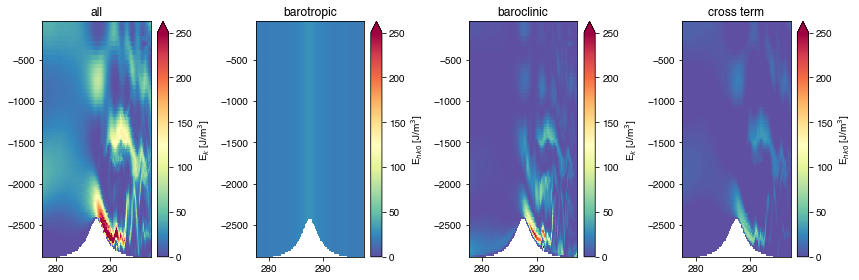

In [25]:
fig,ax = plt.subplots(ncols=4,figsize=(12,4))

TimeStep = -1
MaxC = 250

# all
EkMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ek[TimeStep,:,:]))
h = ax[0].pcolormesh(dist,grid.Z,EkMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[0])
plt.colorbar(h,extend='max',label='E$_k$ [J/m$^3$]',ax=ax[0]);
ax[0].set_title('all')

# barotropic
Ehk0Masked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ehk0m[TimeStep,:,:]))
h = ax[1].pcolormesh(dist,grid.Z,Ehk0Masked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[1])
plt.colorbar(h,extend='max',label='E$_{hk0}$ [J/m$^3$]',ax=ax[1]);
ax[1].set_title('barotropic')

# baroclinic
EkpMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ekp[TimeStep,:,:]))
h = ax[2].pcolormesh(dist,grid.Z,EkpMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[2])
plt.colorbar(h,extend='max',label='E''$_k$ [J/m$^3$]',ax=ax[2]);
ax[2].set_title('baroclinic')

# cross-terms
Ehk0pMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ehk0p[TimeStep,:,:]))
h = ax[3].pcolormesh(dist,grid.Z,Ehk0pMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[3])
plt.colorbar(h,extend='max',label='E$_{hk0}$ [J/m$^3$]',ax=ax[3]);
ax[3].set_title('cross term')

plt.tight_layout()

Depth-integrated kinetic energy. Cross term should come out to zero.

In [26]:
EkDepthIntegral = np.nansum(Ek*drFC*hfacC,axis=1) + Ek[:,0,:]*eta
EkpDepthIntegral = np.nansum(Ekp*drFC*hfacC,axis=1) + Ekp[:,0,:]*eta
Ehk0pDepthIntegral = np.nansum(Ehk0p*drFC*hfacC,axis=1) + Ehk0p[:,0,:]*eta
Ehk0DepthIntegral = np.nansum(Ehk0m*drFC*hfacC,axis=1) + Ehk0*eta

Plot all kinetic energy terms for one time step.

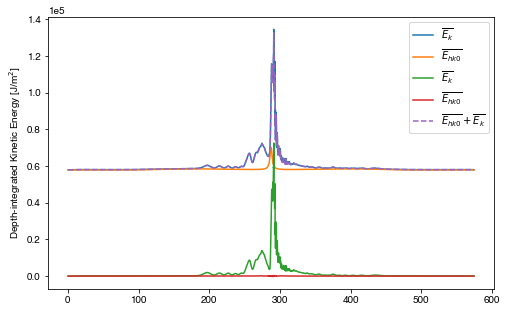

In [27]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(dist,EkDepthIntegral[-1,:],label='$\overline{E_k}$')
ax.plot(dist,Ehk0DepthIntegral[-1,:],label='$\overline{E_{hk0}}$')
ax.plot(dist,EkpDepthIntegral[-1,:],label='$\overline{E''_k}$')
ax.plot(dist,Ehk0pDepthIntegral[-1,:],label='$\overline{E''_{hk0}}$')
ax.plot(dist,Ehk0DepthIntegral[-1,:]+EkpDepthIntegral[-1,:],
         linestyle='--',label='$\overline{E_{hk0}} + \overline{E''_k}$')
ax.legend();
ax.set(ylabel='Depth-integrated Kinetic Energy [J/m$^2$]');

Temporal evolution of depth-integrated baroclinic and barotropic kinetic energy.

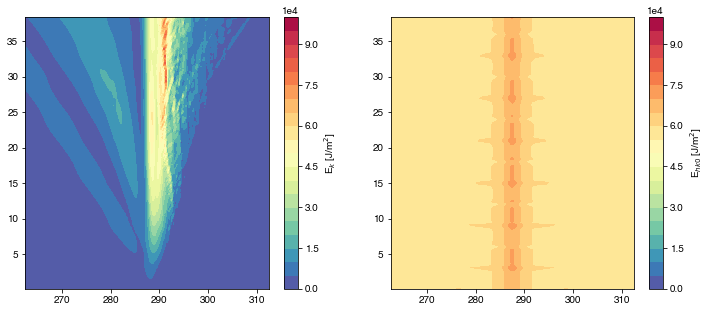

In [28]:
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
h = ax[0].contourf(dist,time,EkpDepthIntegral,np.linspace(0,1e5,21),cmap='Spectral_r')
plt.colorbar(h,ax=ax[0],label='E''$_k$ [J/m$^2$]')
CenterPlot(25,ax[0])

h = ax[1].contourf(dist,time,Ehk0DepthIntegral,np.linspace(0,1e5,21),cmap='Spectral_r')
plt.colorbar(h,ax=ax[1],label='E$_{hk0}$ [J/m$^2$]')
CenterPlot(25,ax[1])

### Potential Energy
#### Perturbation Potential Energy
Perturbation potential energy per unit area [J/m$^2$]
$$ \overline{E_{p0}} = \int_0^\eta \rho_0\, g\, z\, dz = 1/2\, \rho_0\, g\, \eta^2$$

In [29]:
Ep0 = 0.5*rho0*gravity*eta**2

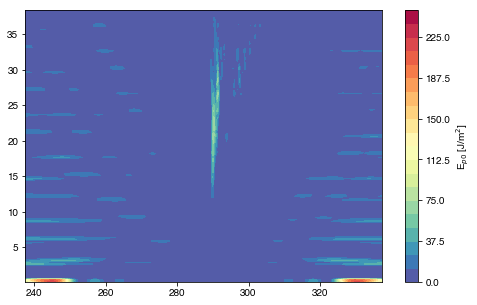

In [30]:
fig,ax = plt.subplots(figsize=(8,5))
h = ax.contourf(dist,time,Ep0,np.linspace(0,2.5e2,21),cmap='Spectral_r')
plt.colorbar(h,extend='max',label='E$_{p0}$ [J/m$^2$]');
CenterPlot()

#### Available Potential Energy

Available potential energy per unit volume [J/m$^3$]
$$  E_p' = \int_{z-\zeta}^z g [\rho(z)-\rho_r(z')]dz' $$

The APE can be approximated with the Linear Available Potential Energy Density, $APE$ and $APE_{lin}$ are the same when the stratification of the fluid is constant.
$$ APE_{lin} = \frac{g^2 \rho'^2}{2 \rho_0 N^2} $$
with
$$ N^2 = \frac{g}{\rho_0} \frac{\partial \rho'}{\partial z}$$

In this case, we can use the linearized APE but would have to create a look-up table for the vertical distance of a given density to the reference density profile if stratification was non-linear.

In [31]:
Epp = gravity**2*(rhopert*BathyMaskNaN)**2/(2*rho0*1e-6)

Calculate APE following Lamb as in the lee wave paper

In [32]:
# def CalculateAPE(ty, ctd):
#     ffsg = np.array(ctd['sg4filt'])
#     ffz = np.array(ctd['z'])
#     Ea = np.array([])
#     for sg4 in ty.gsw_sigma4.values.T:
#     # sg4 = ty.gsw_sigma4.values[:,11]
#         zz = ty.z.values
#         H = np.array([])
#         drho = np.array([])
#         for r, z in zip(sg4, zz):
#             if ~np.isnan(r) and r>InterfaceSG4:
#                 if r>np.max(sg4):
#                     H = np.append(H, 5300-z)
#                     i2 = gv.near(ffz, 5300)
#                     iz = gv.near(ffz, z) # index of far field depth == towyo depth
#                     drho = np.append(drho, r-(np.nanmean(ffsg[iz:i2])))
#                 elif r>InterfaceSG4:
#                     i2 = gv.near(ffsg, r) # index of far field sg==towyo sigma
#                     iz = gv.near(ffz, z) # index of far field depth == towyo depth
#                     H = np.append(H, ffz[i2]-z)
#                     drho = np.append(drho, r-(np.nanmean(ffsg[iz:i2])))

#         Eatmp = gsw.grav(np.nanmean(ty.lat)) * np.nanmean(H*drho)
#         Ea = np.append(Ea, Eatmp)
#     ty['APE'] = (['x'], Ea)
#     return ty

Depth-integrated APE

In [33]:
EppDepthIntegral = np.nansum(Epp*drFC*hfacC,axis=1)

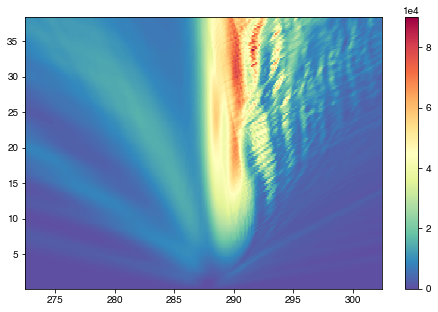

In [34]:
fig,ax = plt.subplots(figsize=(8,5))
h = ax.pcolormesh(dist,time,EppDepthIntegral,cmap='Spectral_r')
CenterPlot(15)
plt.colorbar(h,ax=ax)

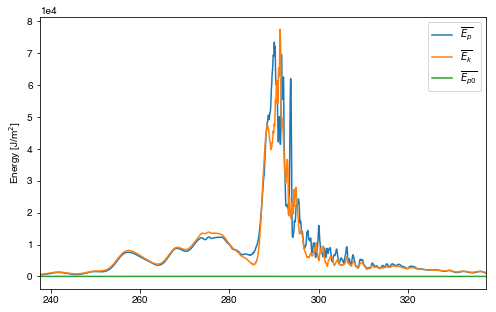

In [35]:
ti = -10
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(dist,EppDepthIntegral[ti,:],label='$\overline{E''_p}$')
# ax.plot(grid.Y/1e3,Ekind[ti,:],label='KE')
ax.plot(dist,EkpDepthIntegral[ti,:],label='$\overline{E''_k}$')
ax.plot(dist,Ep0[ti,:],label='$\overline{E_{p0}}$')
ax.legend()
ax.set(ylabel='Energy [J/m$^2$]')
CenterPlot()

In [36]:
E = EppDepthIntegral+Ep0+EkDepthIntegral

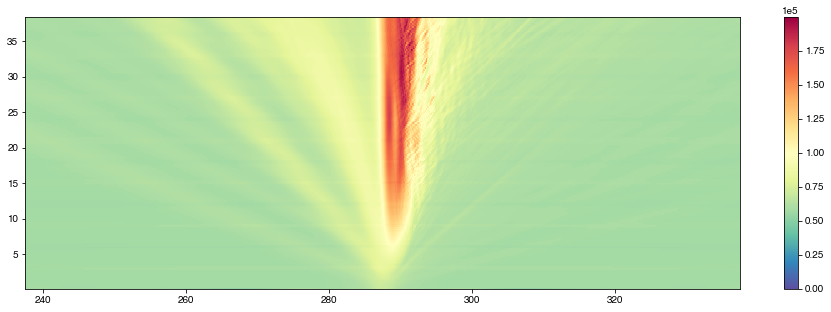

In [37]:
fig,ax = plt.subplots(figsize=(16,5))
h = ax.pcolormesh(dist,time,E,cmap='Spectral_r',vmin=0)
plt.colorbar(h)
CenterPlot(50,ax=ax)

## Total Energy equation
The depth-integrated total energy equation describes the sum of time derivative and fluxes and equals this to dissipation and drag. Units are W/m$^2$.

### Advective Flux Divergence
$$\nabla_H \cdot (\overline{\mathbf{u}_H E_k} + \overline{\mathbf{u}_H E'_p})$$

In [38]:
EkFlux = VC*Ek
# note: np.gradient second argument is distance if scalar but coordinates if vector.
DivEkFlux = np.gradient(np.nansum(EkFlux*drFC,axis=1),grid.Y,axis=1)
EppFlux = VC*Epp
DivEppFlux = np.gradient(np.nansum(EppFlux*drFC,axis=1),grid.Y,axis=1)
DivAdvFlux = np.gradient(np.nansum(EppFlux*drFC,axis=1)+np.nansum(EkFlux*drFC,axis=1),grid.Y,axis=1)

Plot time evolution of advective flux divergences.

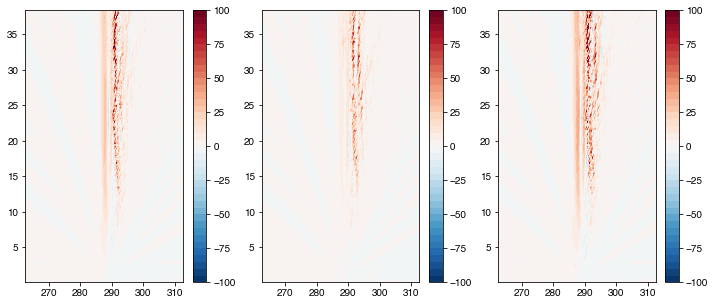

In [39]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
h = ax[0].contourf(dist,time,DivEkFlux,np.linspace(-100,100,41),cmap='RdBu_r')
plt.colorbar(h,ax=ax[0])
CenterPlot(25,ax[0])
h = ax[1].contourf(dist,time,DivEppFlux,np.linspace(-100,100,41),cmap='RdBu_r')
plt.colorbar(h,ax=ax[1])
CenterPlot(25,ax[1])
h = ax[2].contourf(dist,time,DivAdvFlux,np.linspace(-100,100,41),cmap='RdBu_r')
plt.colorbar(h,ax=ax[2])
CenterPlot(25,ax[2])

### Pressure Flux Divergence
$$\nabla_H \cdot ( \mathbf{U}_H H \rho_0 g \eta +   \overline{\mathbf{u}_H p'} + \overline{\mathbf{u}_H q})$$

The term related to the free surface anomaly becomes really big. It won't show up in the baroclinic energy equations anymore though, so shouldn't bother us too much.

In [40]:
DivBaroPressureFlux = np.gradient(V*H*rho0*gravity*eta,grid.Y,axis=1)
DivPressureFlux = np.gradient(np.nansum(VC*PP*drFC,axis=1)+eta*VC[:,0,:]*PP[:,0,:],grid.Y,axis=1)
DivnhPressureFlux = np.gradient(np.nansum(VC*q*drFC,axis=1)+eta*VC[:,0,:]*q[:,0,:],grid.Y,axis=1)

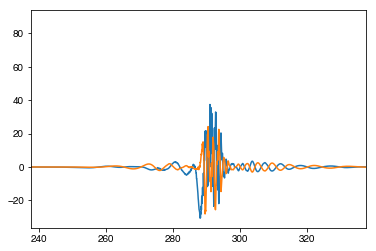

In [41]:
# plt.plot(dist,DivBaroPressureFlux[-1,:])
plt.plot(dist,DivPressureFlux[-100,:])
plt.plot(dist,DivnhPressureFlux[-100,:]);
CenterPlot(50)

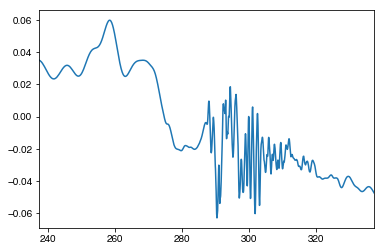

In [42]:
plt.plot(dist,eta[-10,:])
CenterPlot(50)

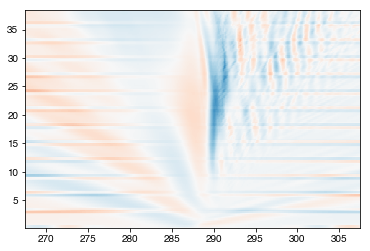

In [43]:
plt.pcolormesh(dist,time,eta,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
CenterPlot(20)


<function matplotlib.pyplot.colorbar>

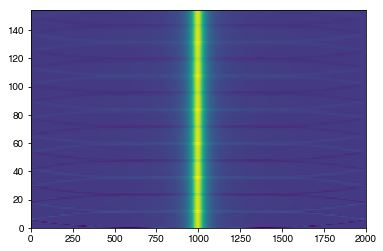

In [44]:
plt.pcolormesh(V)
plt.colorbar

### Diffusive Flux Divergence
$$ - \overline{ \nabla_H \cdot (\nu_H \nabla_H E_k) }  -  \overline{ \nabla_H \cdot (\kappa_H g \zeta \nabla_H \rho') } $$
with the horizontal eddy viscosity (`viscAh`)
$$\nu_H=10^{-4} \mathrm{m}^2/\mathrm{s}$$ 
and horizontal diffusivity of heat (and thereby mass with the LES, `diffKhT`):
$$\kappa_H=10^{-4} \mathrm{m}^2/\mathrm{s}$$ 

In [45]:
nuh = 1e-4
kappah = 1e-4
nuz = 1e-5
kappaz = 1e-5

In [46]:
DivDiffEk = -np.nansum(np.gradient((nuh*np.gradient(Ek,grid.Y,axis=2)),grid.Y,axis=2)*drFC,axis=1)
# DivDiffEp = 

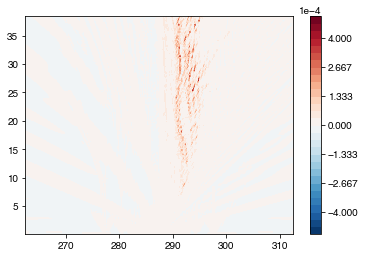

In [47]:
plt.contourf(dist,time,DivDiffEk,np.linspace(-5e-4,5e-4,31),cmap='RdBu_r')
plt.colorbar()
CenterPlot(25)

Diffusion is tiny compared to other terms. This may be right though, in [Kang and Fringer (2012)](http://journals.ametsoc.org/doi/abs/10.1175/JPO-D-11-039.1), diffusion contributes only 0.002% to the baroclinic energy flux divergence within a subdomain of their model.

## Buoyancy Flux and BT-BC Conversion

The buoyancy flux is defined as
$$F_B = \rho' g w$$
and the depth-integrated buoyancy flux within a fixed water column as
$$\overline{F_B} = \int_{-d}^{\eta} \rho' g w\, dz $$
with density perturbation $\rho'$, gravity $g$ and vertical velocity $w$.

The barotropic to baroclinic conversion term is defined as
$$F_{Conv} = \overline{\rho' g W}$$
with the barotropic vertical velocity $W$.

In [48]:
BuoyancyFlux = gravity*rhopert*WC

In [49]:
BTBCConversion = gravity*rhopert*W3*BathyMaskNaN

Depth integrals of buoyancy flux and BT-BC conversion

In [50]:
# calculate depth at the grid faces from drF and HFacS
# DepthC = np.sum(drFC*np.squeeze(grid.HFacC.values),axis=0)
BuoyancyFluxDepthIntegral = np.nansum(BuoyancyFlux*drFC*hfacC,axis=1)
BTBCConversionDepthIntegral = np.nansum(BTBCConversion*drFC*hfacC,axis=1)

The BT-BC conversion also has the non-hydrostatic part
$$\overline{\frac{\partial q}{\partial z} W}$$

In [51]:
# drC = np.tile(grid.drC.values.T,(2000,1))
# drC = drC.T
# qz = np.gradient(q,axis=1)/((drC[1:,:] + drC[:-1,:])/2)
# qz = (qz[1:,:,:] + qz[:-1,:,:])/2

qz = np.gradient(q,grid.Z,axis=1)

In [52]:
nhBTBCConversion = qz*W3*BathyMaskNaN

Depth-integrated non-hydrostatic conversion

In [53]:
nhBTBCConversionDepthIntegral = np.nansum(nhBTBCConversion*drFC*hfacC,axis=1)

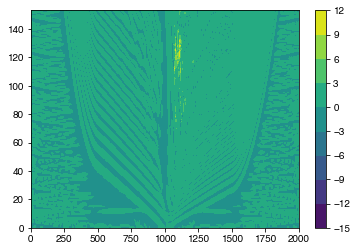

In [54]:
plt.contourf(nhBTBCConversionDepthIntegral)
plt.colorbar()

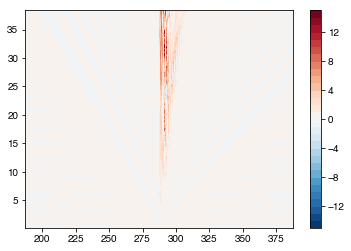

In [55]:
plt.contourf(dist,time,BTBCConversionDepthIntegral-nhBTBCConversionDepthIntegral,
            np.linspace(-15,15,31),cmap='RdBu_r')
plt.colorbar()
CenterPlot(100)

[(-1, 1)]

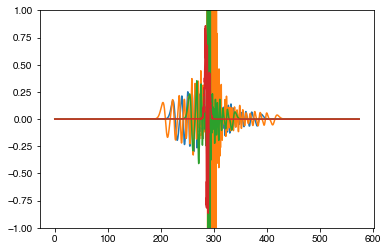

In [56]:
plt.plot(dist,BTBCConversionDepthIntegral[-50,:])
plt.plot(dist,BTBCConversionDepthIntegral[-20,:])
plt.plot(dist,BTBCConversionDepthIntegral[-100,:])
plt.plot(dist,BTBCConversionDepthIntegral[5,:])
plt.gca().set(ylim=(-1,1))

In [57]:
HorizontalExtent = slice(200,800)
print(np.nansum(BTBCConversionDepthIntegral[-1,HorizontalExtent]*dyF[HorizontalExtent]))
print(np.nansum(nhBTBCConversionDepthIntegral[-1,HorizontalExtent]*dyF[HorizontalExtent]))


2411.40401271
-3.11846424352


## Turbulent Dissipation
Integrate turbulent dissipation with depth

In [58]:
eps = np.squeeze(b6.KLeps.values)*BathyMaskNaN

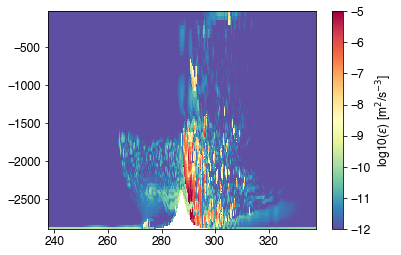

In [76]:
plt.pcolormesh(grid.Y/1e3,grid.Z,np.ma.masked_where(np.squeeze(grid.HFacC)<1,np.log10(eps[150,:,:])),vmin=-12,vmax=-5,cmap='Spectral_r')
plt.colorbar(label=r'log10($\epsilon$) [m$^2$/s$^{-3}$]')
CenterPlot()

In [60]:
epsDepthIntegral = np.nansum(rho0*hfacC*eps*drFC,axis=1)

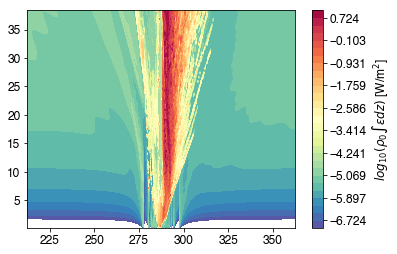

In [82]:
fig,ax = plt.subplots()
h = ax.contourf(dist,time,np.log10(epsDepthIntegral),np.linspace(-7,1,30),cmap='Spectral_r')
# ax.set(ylabel=r'$\int \rho \epsilon \,  dz$ [W\m$^2$]',xlabel='distance [km]')
CenterPlot(75,ax)
plt.colorbar(h,ax=ax,label=r'$log_{10}(\rho_0 \int \epsilon dz)$ [W/m$^2$]');

## Baroclinic energy equations
Terms of the baroclinic energy equations. Different to Kang (2011) we'll do this not only depth-integrated, but also integrated across the ridge in the horizontal. Thus, the equation will be expressed in units of W/m.

In [62]:
AdvectiveTimeScale = 0.2*time[-1]*3600/1e3

In [63]:
# integrate over this distance in km left and right of the ridge
dy = 30
yi = np.squeeze(np.where( (dist>my-dy) & (dist<my+dy) ))

The advective lateral scale for the whole model run is about {{round(AdvectiveTimeScale)}}km. Well start out with integrating {{round(dy)}}km on each side of the ridge.

### Unsteadiness
$$ \frac{\partial}{\partial t} (\iint E'_k dy dz + \iint E'_p dy dz)$$

In [65]:
EkpVI = np.sum(EkpDepthIntegral[:,yi]*dyF[yi],axis=1) # VI stands for volume integral
EppVI = np.sum(EppDepthIntegral[:,yi]*dyF[yi],axis=1) # VI stands for volume integral
# time derivative
dEkpVIdt = np.gradient(EkpVI,time)
dEppVIdt = np.gradient(EppVI,time)
BC_Unsteadiness = dEkpVIdt+dEppVIdt

[<matplotlib.text.Text at 0x2daaf8128>, <matplotlib.text.Text at 0x2ca8fd4e0>]

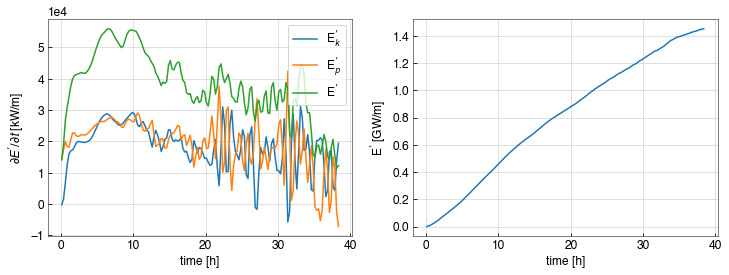

In [103]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# fig,ax = gvf.newfig()
ax[0].plot(time,dEkpVIdt/1e3,label='E$^\prime_k$')
ax[0].plot(time,dEppVIdt/1e3,label='E$^\prime_p$')
ax[0].plot(time,BC_Unsteadiness/1e3,label='E$^\prime$')
ax[0].set(xlabel='time [h]',ylabel='$\partial E^\prime / \partial t$ [kW/m]')
ax[0].legend()
ax[1].plot(time,(EkpVI+EppVI)/1e9)
ax[1].set(ylabel='E$^\prime$ [GW/m]',xlabel='time [h]');

In [113]:
PotentialBarotropicKineticenergyAccumulation = 1/2*rho0*0.2**2*3000*time[-1]*3600/1e9

After initial spinup, there is a relatively constant input of 40 MW/m into baroclinic energy within the control volume. A total of more than 1 GW accumulates in the baroclinic flow- and pressure field. For comparison, the total energy that could be extracted over the time of the model run from barotropic flow of 0.2 m/s over 3000 m depth would be close to {{round(PotentialBarotropicKineticenergyAccumulation)}} GW.

### BT/BC Conversion

In [120]:
BTBCConversionVI = np.sum(BTBCConversionDepthIntegral[:,yi]*dyF[yi],axis=1)
nhBTBCConversionVI = np.sum(nhBTBCConversionDepthIntegral[:,yi]*dyF[yi],axis=1)

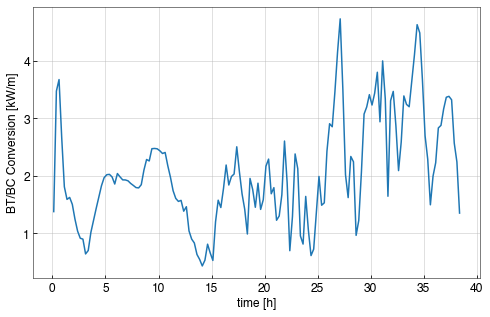

In [121]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot(time,(BTBCConversionVI-nhBTBCConversionVI)/1e3)
ax.set(ylabel='BT/BC Conversion [kW/m]',xlabel='time [h]');

### Flux-Advection

In [126]:
EkpFluxDepthIntegral = np.nansum(VC*Ekp*drFC*hfacC,axis=1)
EppFluxDepthIntegral = np.nansum(VC*Epp*drFC*hfacC,axis=1)
Ehk0pFluxDepthIntegral = np.nansum(VC*Ehk0p*drFC*hfacC,axis=1)

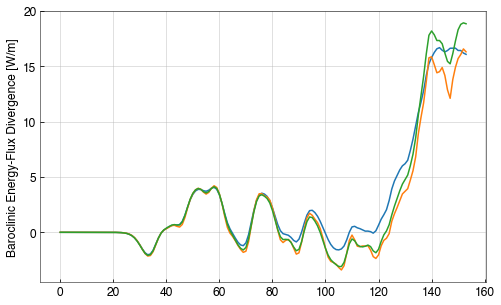

In [136]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot((EkpFluxDepthIntegral[:,yi[0]]-EkpFluxDepthIntegral[:,yi[-1]])/(dist[yi[-1]]-dist[yi[0]]))
ax.plot((EppFluxDepthIntegral[:,yi[0]]-EppFluxDepthIntegral[:,yi[-1]])/(dist[yi[-1]]-dist[yi[0]]))
ax.plot((Ehk0pFluxDepthIntegral[:,yi[0]]-Ehk0pFluxDepthIntegral[:,yi[-1]])/(dist[yi[-1]]-dist[yi[0]]))
# plt.plot(EkpFluxDepthIntegral[:,yi[-1]])
# plt.plot(EppFluxDepthIntegral[:,yi[0]])
# plt.plot(EppFluxDepthIntegral[:,yi[-1]])
# plt.plot(Ehk0pFluxDepthIntegral[:,yi[0]])
# plt.plot(Ehk0pFluxDepthIntegral[:,yi[-1]])
ax.set(ylabel='Baroclinic Energy-Flux Divergence [W/m]')

### Flux-Pressure

## Form Drag

The form drag per unit width (as we are working in 2D) is:
$$D_{Form} = - \int P_{bot}\, dh/dy\, dy$$

Depth is defined at cell centers, $dH/dy$ will be defined on the cell faces. We'll interpolate back to cell centers since bottom pressure is defined here.

The bottom pressure anomaly vs. time looks like this:

In [ ]:
b62.PHIBOT

In [ ]:
b62.PHIBOT.plot();

In [ ]:
# first calculate dh/dy on cell faces since depth is given for cell center
dhdyF = np.squeeze(0.*grid.YG.values[:,0])
test = grid.Depth.diff(dim='Y').values/grid['dyC'].values[1:-1]
dhdyF[1:-1] = np.squeeze(test)
# interpolate to grid centers
from scipy.interpolate import interp1d
f = interp1d(np.squeeze(grid.YG.values[:,0]),dhdyF,bounds_error=False)
dhdy = f(grid.Y.values)

DF = np.squeeze(b62.PHIBOT.values)*rho0*dhdy

# from jody https://github.com/jklymak/LW1kmPython/blob/master/GetEnergyBudget.py
# dhdx = 0.*ds.Depth.values
# dhdx[:,1:] = ds.Depth.diff(dim='XC').values/ds['dxC'].values
# dhdx[:,0]=(grid.Depth[:,-1]-grid.Depth[:,0])/grid['dyC'][0,0]

In [ ]:
plt.pcolormesh(grid.Y.values,b6.iter,DF,vmin=-35,vmax=35,cmap='RdBu')
plt.colorbar()
plt.gca().set(xlim=(2.84e5,2.95e5))

Now integrate along $y$:

In [ ]:
DF = np.sum(-DF*np.squeeze(grid.dyF.values),axis=1)

In [ ]:
fig, ax = plt.subplots()
ax.plot(b6['T']/3600,DF)
ax.grid()
ax.set(xlabel='time [hrs]',ylabel='D$_{Form}$ [N/m]',title='Form Drag');

The spikes must be due to the barotropic waves crossing the bump.

The energy lost to form drag is $U D_{Form}$ - not quite sure which velocity to use here. Maybe the upstream velocity 0.2 m/s?

In [ ]:
EDF = DF*0.2
fig, ax = plt.subplots()
ax.plot(b6['T']/3600,EDF)
ax.grid()
ax.set(xlabel='time [hrs]',ylabel='E$_{DForm}$ [J]',title='Energy lost to Form Drag');